# Simulación de errores Pauli en el Algoritmo de Grover

## Abstract

En este notebook, haremos un análisis de diferentes simulaciones de errores Pauli en el Algoritmo de Grover. El respectivo algoritmo, y los experimentos, estan pensados para que unicamente se busque un elemento marcado.

La primera sección del notebook, sera para codear los imports necesarios durantes los experimentos y las funciones comunes que seran de utilidad durante los mismos. En segundo lugar, se hara una ejecución del algoritmo en el hardware de IBM $\textit{ibm_brisbane}$

Luego, se haran multiple simulaciones con el simulador AER. Se agregara un ratio de ruido creciente desde 0 a 1, incrementando en 0.05 por cada experimento. Se mostraran los resultados para cada uno de estos experimentos, para luego representar en un grafico la correlación entre probabilidad de ruido y probabilidad de resultado exitoso. Todo esto se repetira dos veces:

    - La primera vez, para agregar ruido unicamente a compuertas de 1 qubit.
    - La segunda vez, para agregar ruido unicamente a compuertas de 2 qubits.

Finalmente, se analizaran todos los resultados en conjunto y se llegara a una conclusión.

## 1.   Imports y funciones comunes

In [77]:
 pip install qiskit --upgrade

Note: you may need to restart the kernel to use updated packages.


In [78]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.1', 'qiskit': '0.44.1', 'qiskit-aer': '0.12.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [79]:
import numpy as np
from qiskit import QuantumCircuit,QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
import math
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Import for running in IBM Quantum
from  qiskit_ibm_provider import IBMProvider

In [80]:
#OBTENIENDO BACKENDS DE IBMQ
IBMProvider.save_account(token='a9d10e4a8b4991ef8c9c681341574aac9b1bab78eb427aee5d2b079d37a24893001fbdb975f23da614c34590266fa40ccc8cbf6e68ffe0c108464236a4ff6422', overwrite=True)
provider = IBMProvider()
print(provider.backends())
brisbane_backend = provider.get_backend('ibm_brisbane')

[<IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_mps')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('simulator_extended_stabilizer')>]


In [81]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [82]:
def add_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    #print(error)
    
    noiseModel.add_all_qubit_quantum_error(error,gates)
    return noiseModel

def add_controlled_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    noError = pauli_error([('I',1)])
    totalErrorCase = noError.tensor(error)
    #print(totalErrorCase)
    
    noiseModel.add_all_qubit_quantum_error(totalErrorCase,gates)
    return noiseModel


#noise_model = NoiseModel()
#add_pauli_error(noise_model,0.3,0.3,['x','h'])
#add_controlled_pauli_error(noise_model,0.4,0.4,['cx','cz'])

In [83]:
#VARIABLES GLOBALES
marked_states=['010']
nroQubits=3
shots=10000
errorProbabilities = [
    0,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    1
]

#Se crea el operador de grover: oraculo + expansion de estado
oracle = grover_oracle(marked_states)
groverOp = GroverOperator(oracle)

#Se calcula el numero optimo de iteraciones
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**groverOp.num_qubits / len(marked_states))
)

## 2.   Ejecución en hardware real - ibm_brisbane

In [84]:
'''
#ALGORITMO      
qr = QuantumRegister(nroQubits)
qc = QuantumCircuit(qr)
qc.h(qr)
qc.compose(groverOp.decompose(), inplace=True)
qc.measure_all()
#display(qc.draw("mpl"))
#display(qc.data)
    
#EJECUCION
qc_transpiled = transpile(qc,brisbane_backend)
result = brisbane_backend.run(qc_transpiled,shots=shots).result()
counts = results.get_counts(0)
'''

'\n#ALGORITMO      \nqr = QuantumRegister(nroQubits)\nqc = QuantumCircuit(qr)\nqc.h(qr)\nqc.compose(groverOp.decompose(), inplace=True)\nqc.measure_all()\n#display(qc.draw("mpl"))\n#display(qc.data)\n    \n#EJECUCION\nqc_transpiled = transpile(qc,brisbane_backend)\nresult = brisbane_backend.run(qc_transpiled,shots=shots).result()\ncounts = results.get_counts(0)\n'

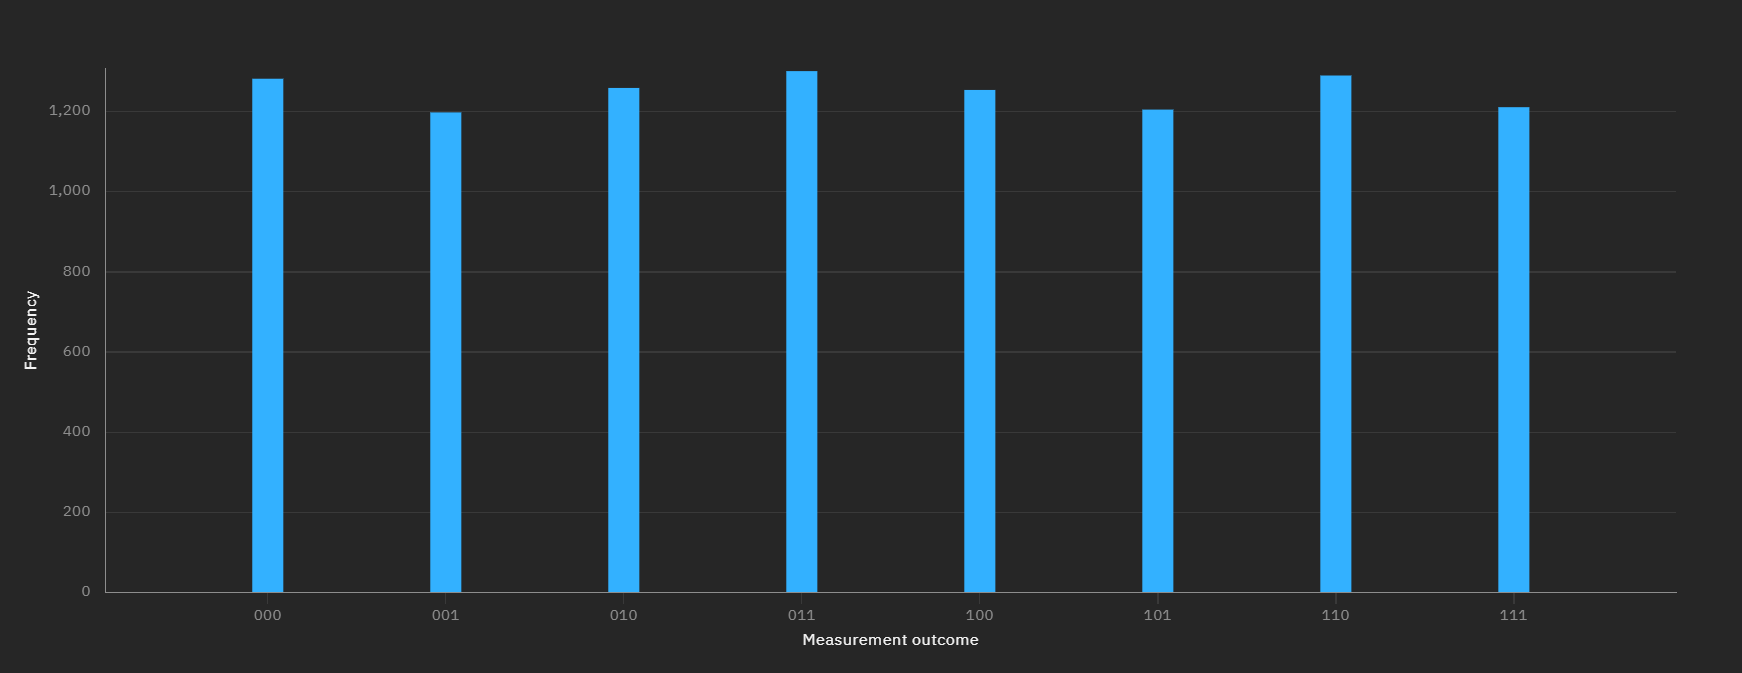

In [85]:
from PIL import Image
img = Image.open(r'C:\Users\54299\Desktop\Facultad\Trabajos\QuantumQuipu\Noise and native gates\QuantumQuipu_NoiseAndNativeGates\Imagenes\ibm_brisbane_hardware_grover_search.png')
display(img)

## Simulaciones

### Errores de Pauli en compuertas de 1 qubit

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


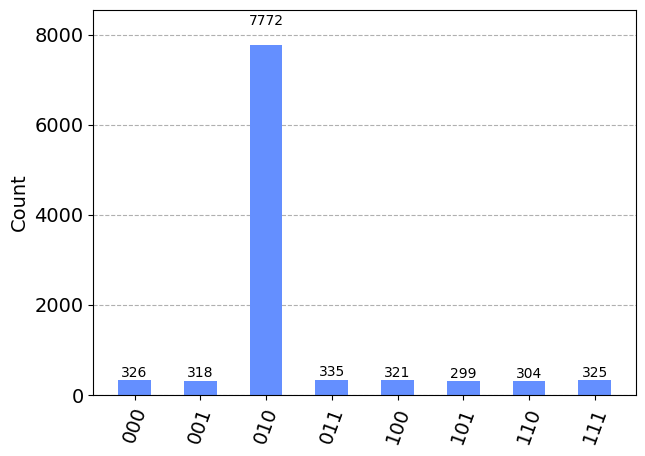

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


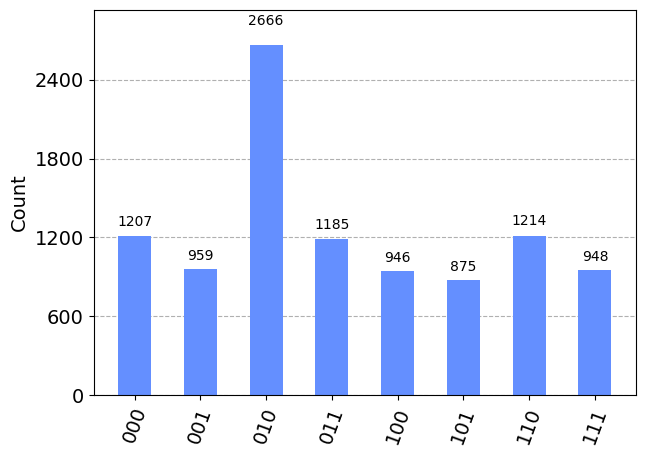

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


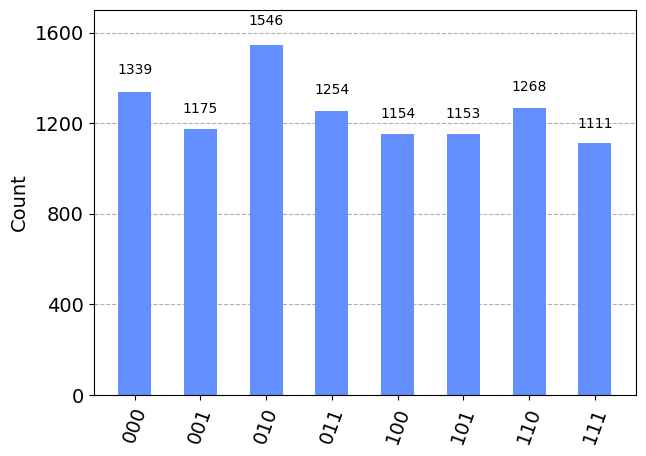

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


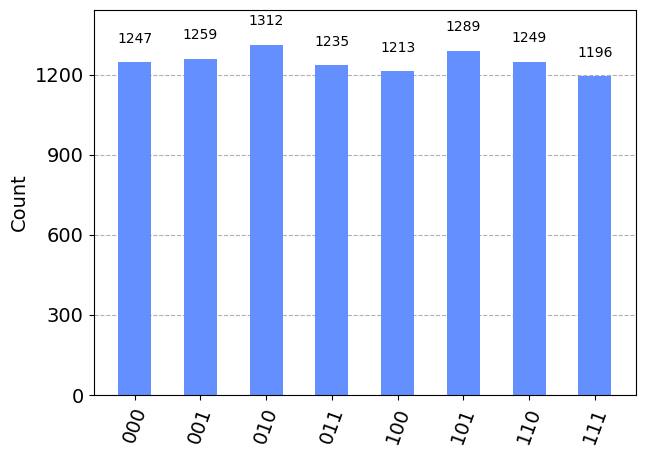

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


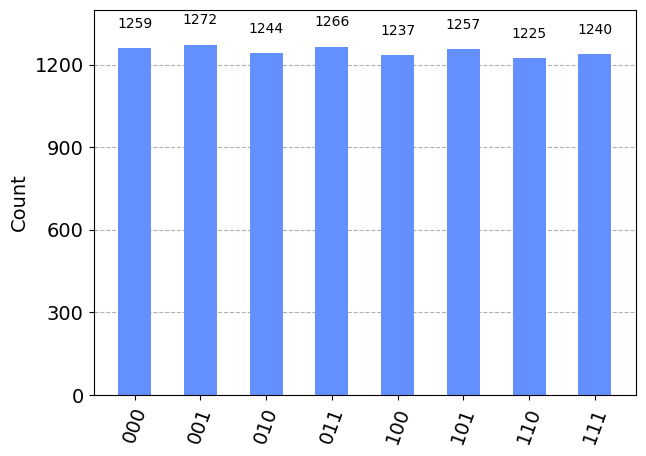

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


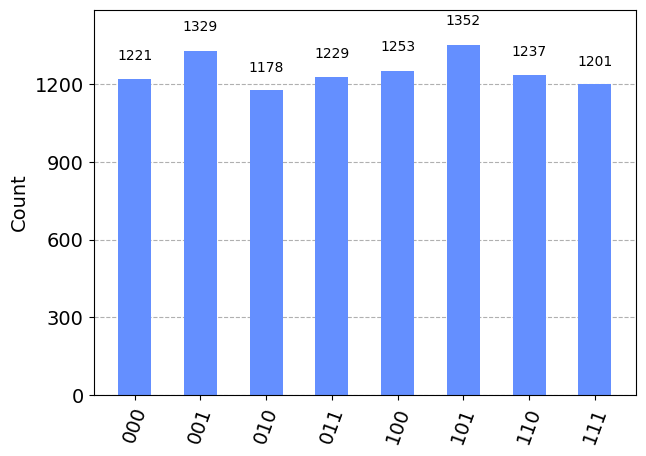

PROBABILIDAD DE ERROR:  0.3
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


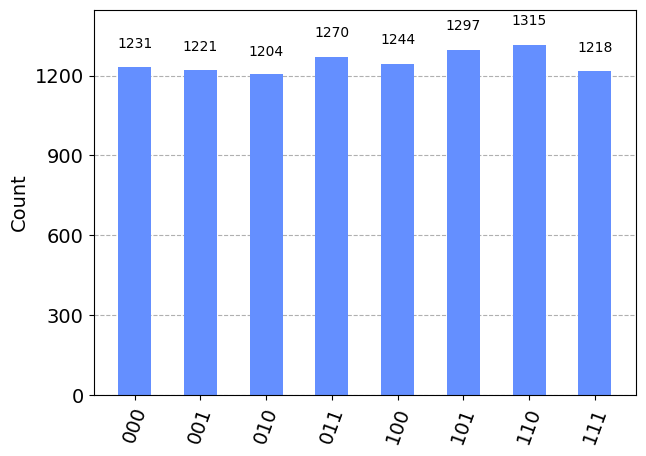

PROBABILIDAD DE ERROR:  0.35
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


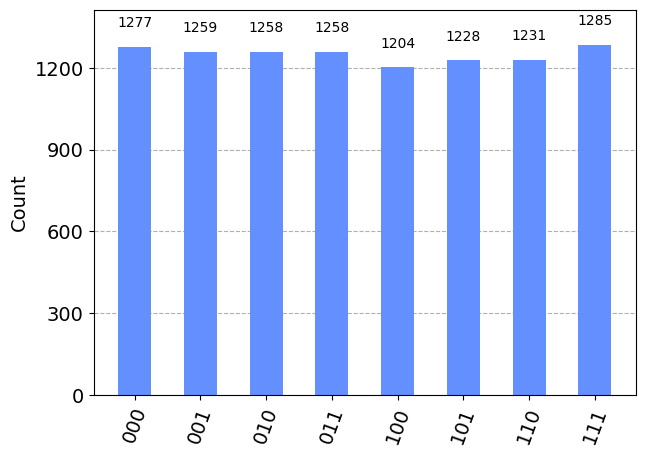

PROBABILIDAD DE ERROR:  0.4
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


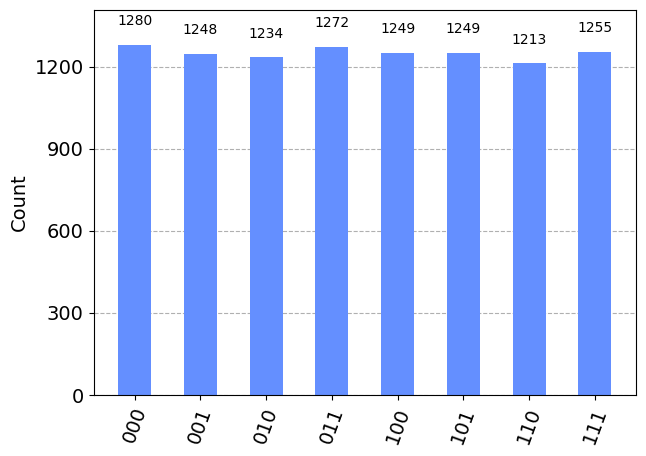

PROBABILIDAD DE ERROR:  0.45
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


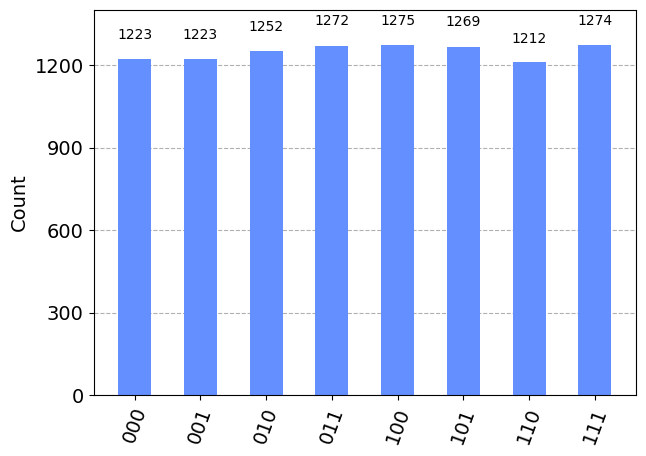

PROBABILIDAD DE ERROR:  0.5
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


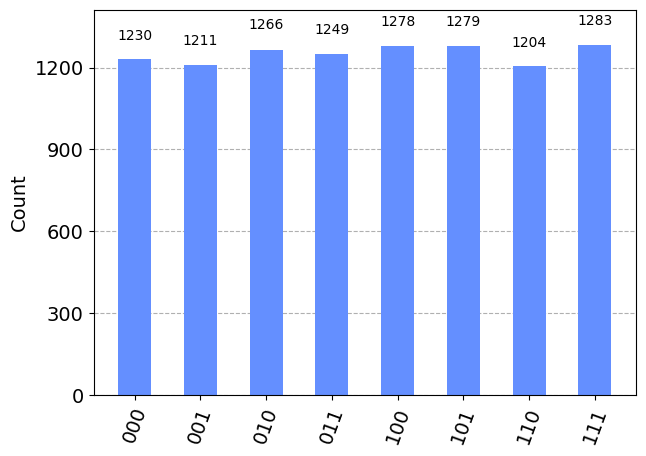

PROBABILIDAD DE ERROR:  0.55
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


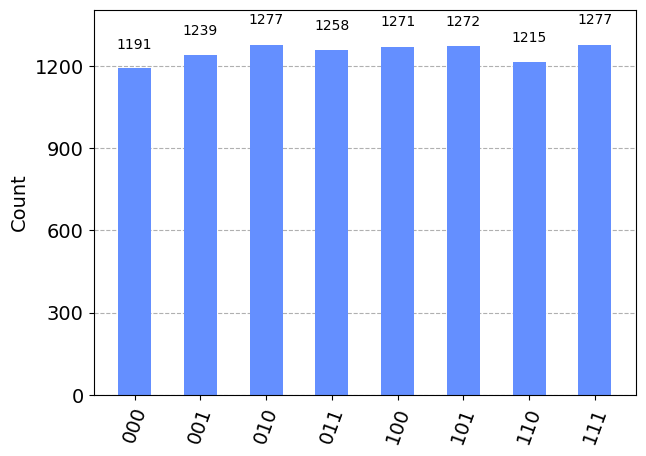

PROBABILIDAD DE ERROR:  0.6
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


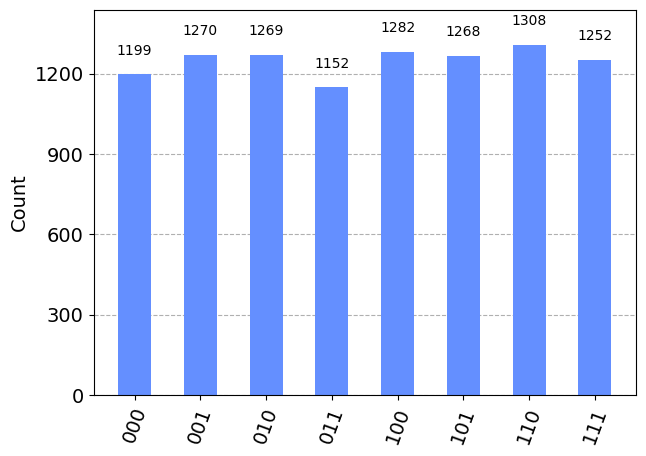

PROBABILIDAD DE ERROR:  0.65
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


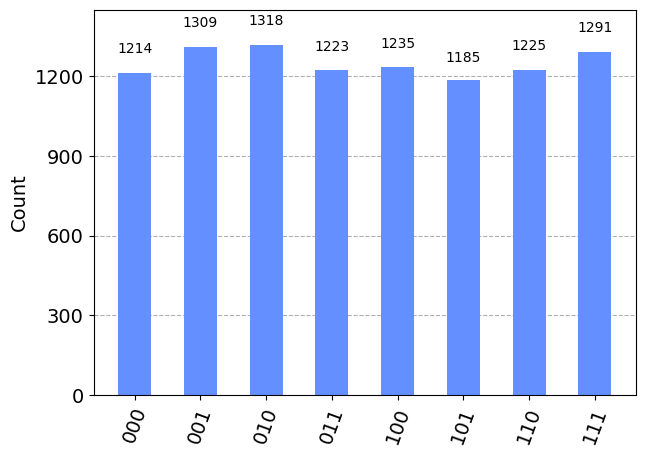

PROBABILIDAD DE ERROR:  0.7
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


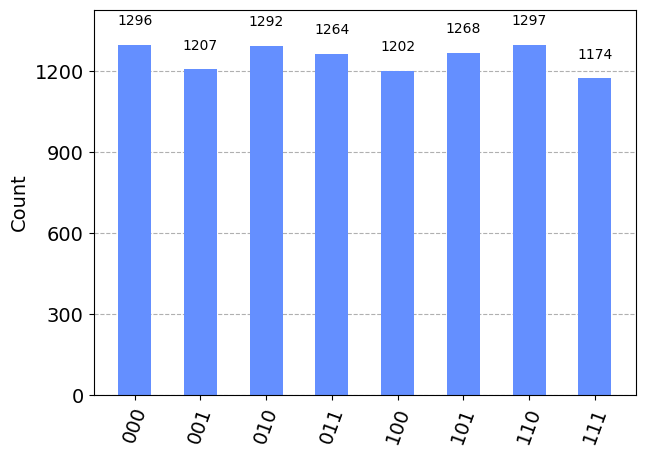

PROBABILIDAD DE ERROR:  0.75
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


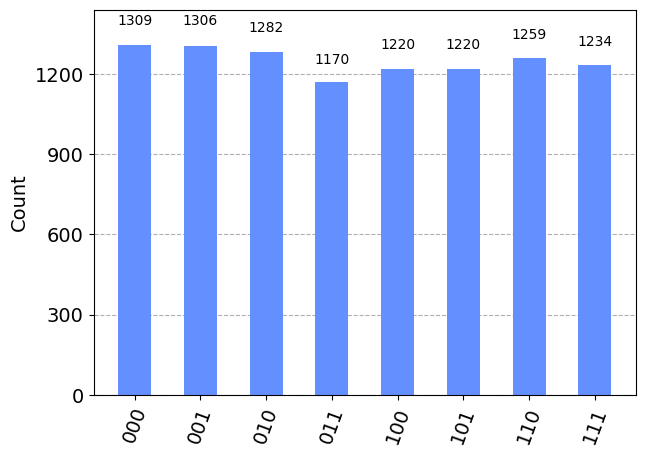

PROBABILIDAD DE ERROR:  0.8
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


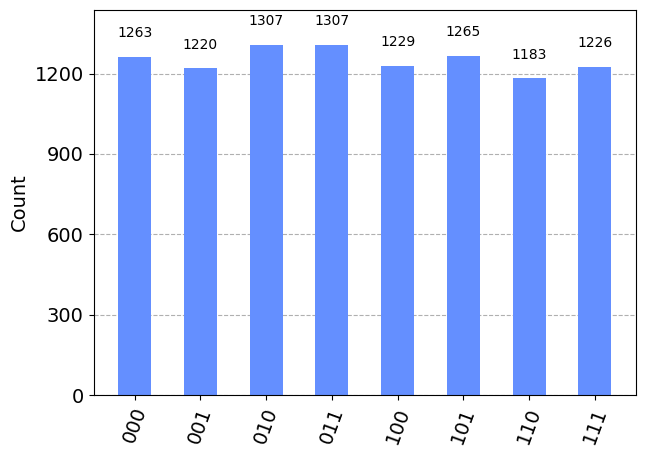

PROBABILIDAD DE ERROR:  0.85
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


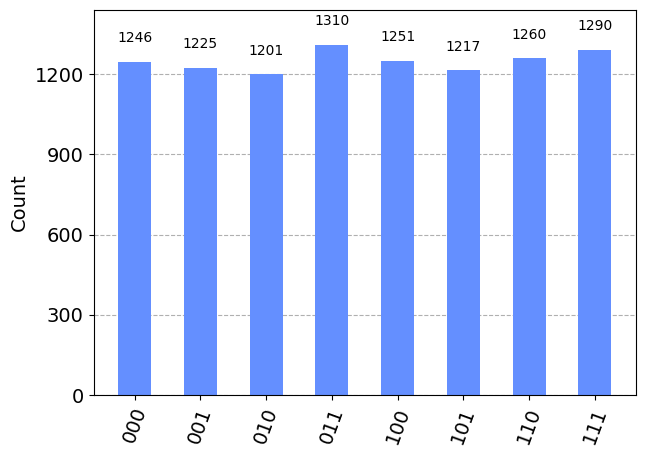

PROBABILIDAD DE ERROR:  0.9
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


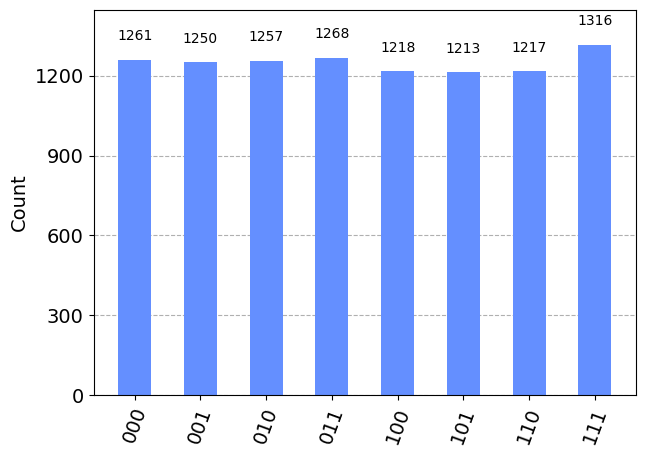

PROBABILIDAD DE ERROR:  0.95
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


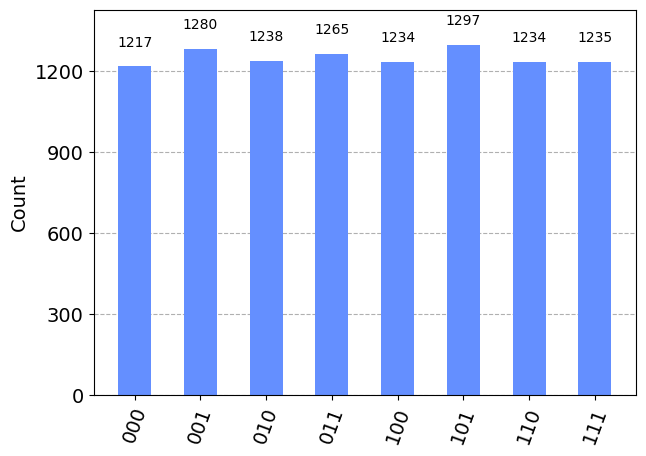

PROBABILIDAD DE ERROR:  1
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'h', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x', 'h']


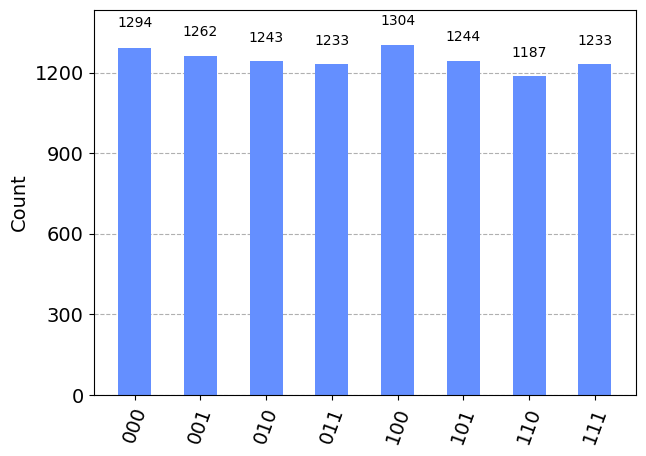

In [87]:
results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
     
    noiseModel = NoiseModel()
    noiseModel = add_pauli_error(noiseModel,i/2,i/2,['sx','rz','x','h'])
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.draw("mpl"))
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)

In [88]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts1=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts1.append(currentCount/shots)
#print(successCounts1)

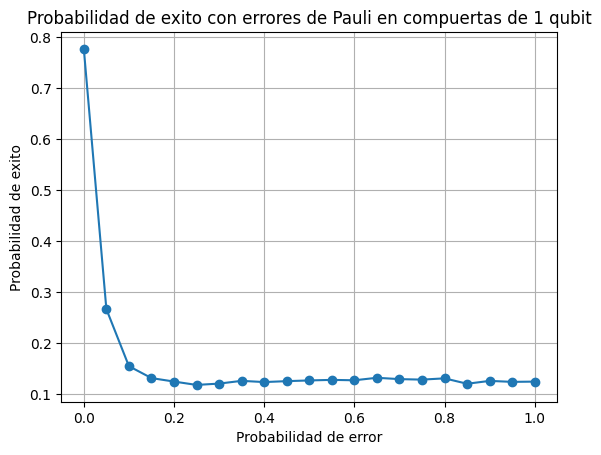

In [89]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts1, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 1 qubit')

# Mostrar el gráfico
plt.grid(True)
plt.show()

### Errores de Pauli en compuertas de 2 qubits

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


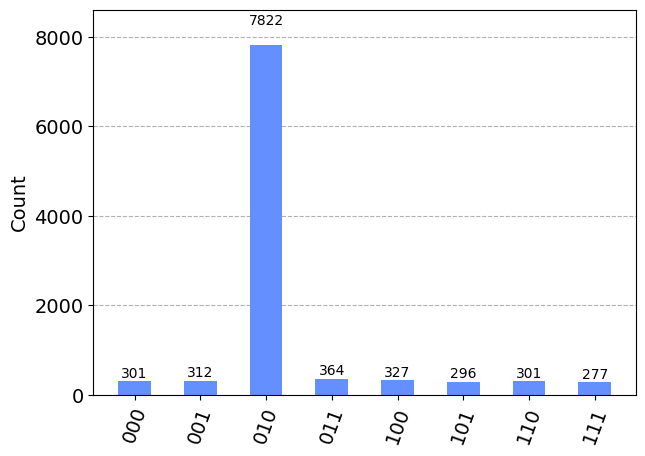

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


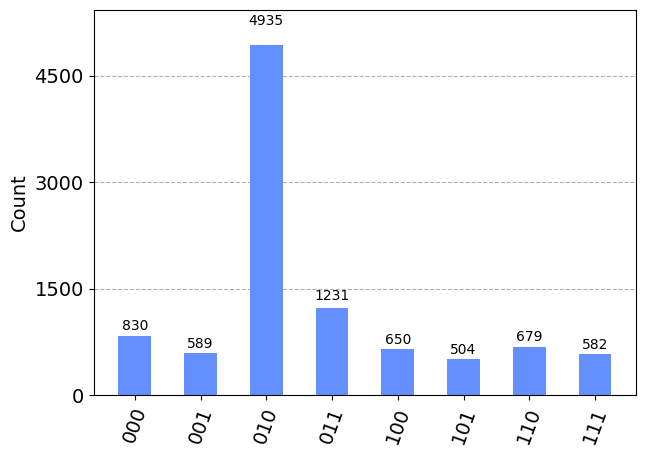

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


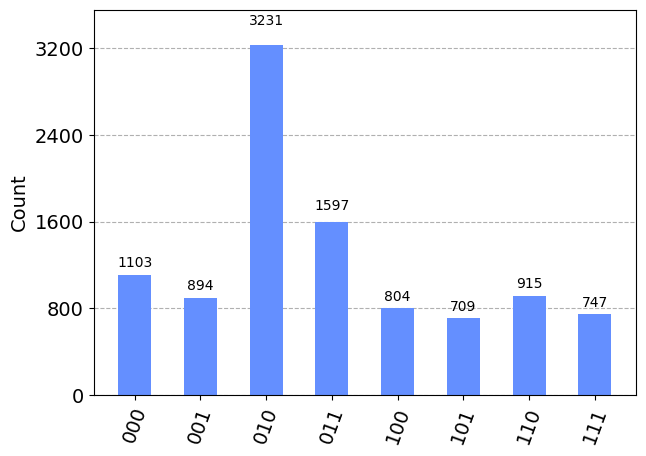

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


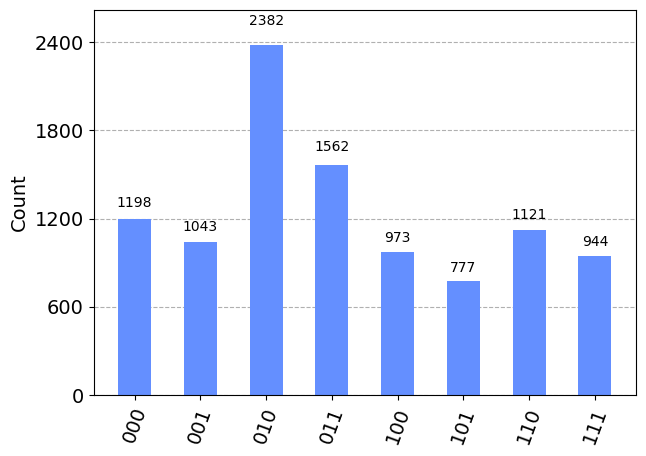

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


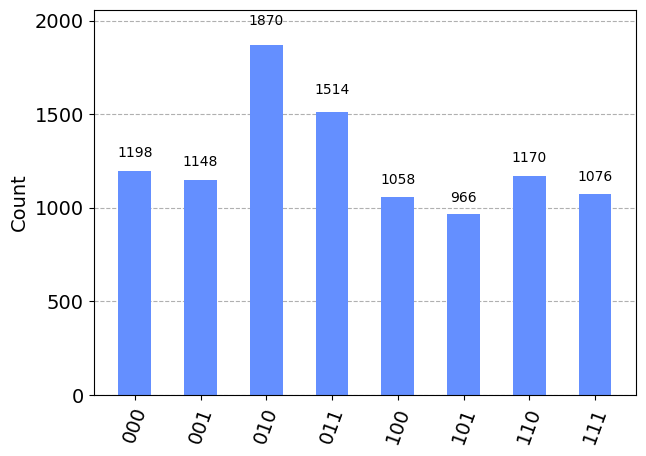

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


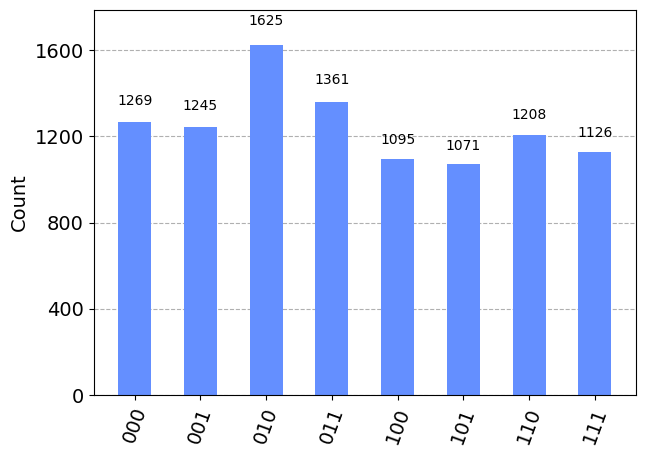

PROBABILIDAD DE ERROR:  0.3
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


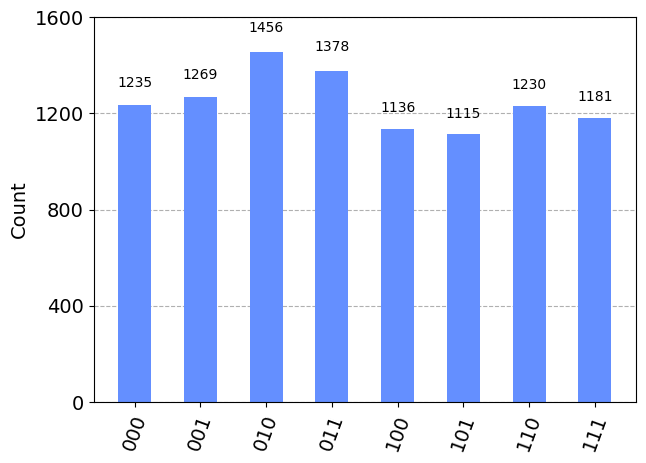

PROBABILIDAD DE ERROR:  0.35
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


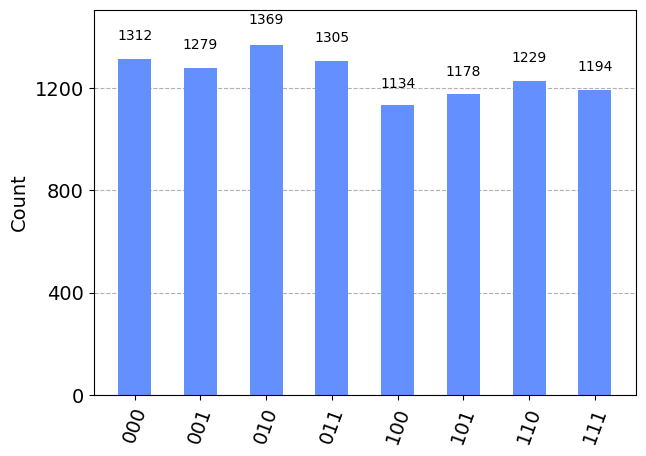

PROBABILIDAD DE ERROR:  0.4
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


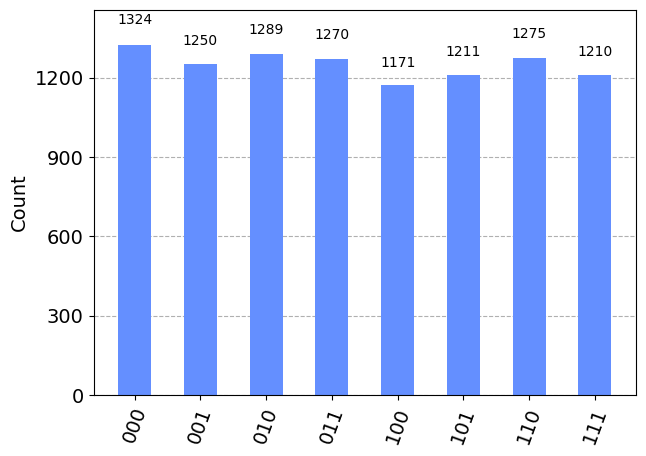

PROBABILIDAD DE ERROR:  0.45
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


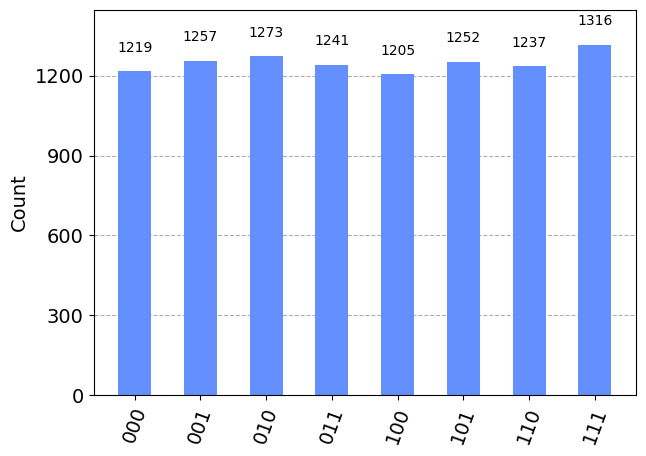

PROBABILIDAD DE ERROR:  0.5
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


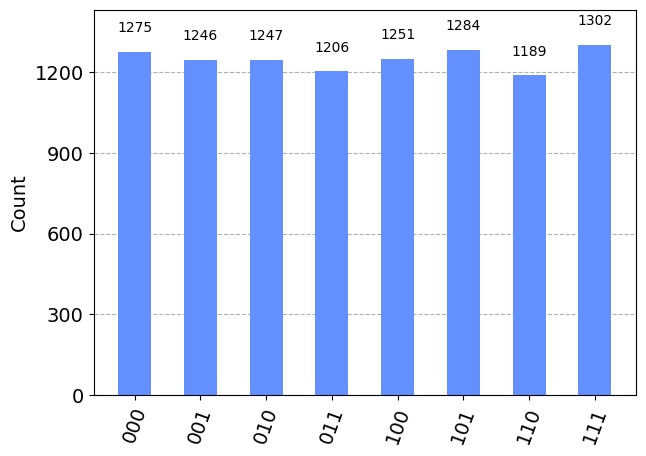

PROBABILIDAD DE ERROR:  0.55
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


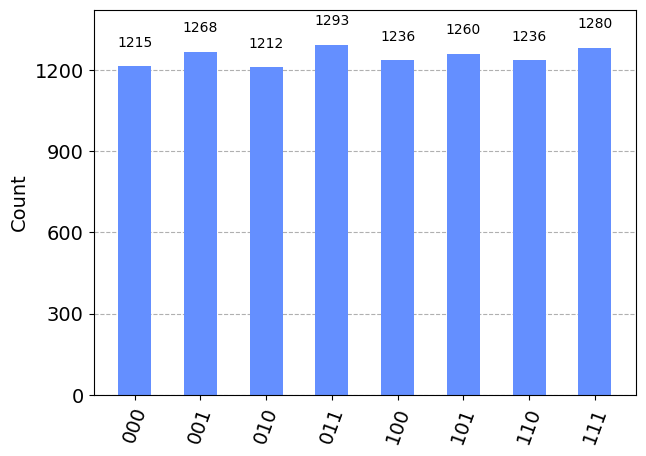

PROBABILIDAD DE ERROR:  0.6
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


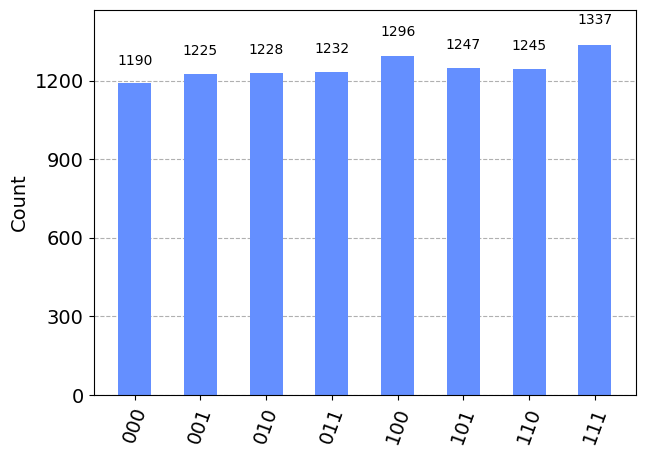

PROBABILIDAD DE ERROR:  0.65
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


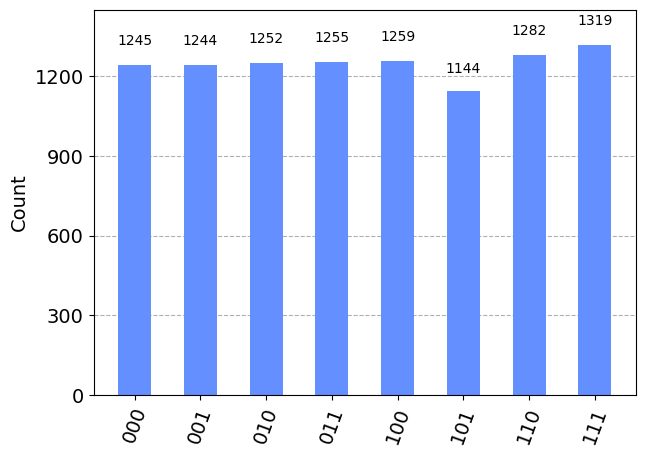

PROBABILIDAD DE ERROR:  0.7
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


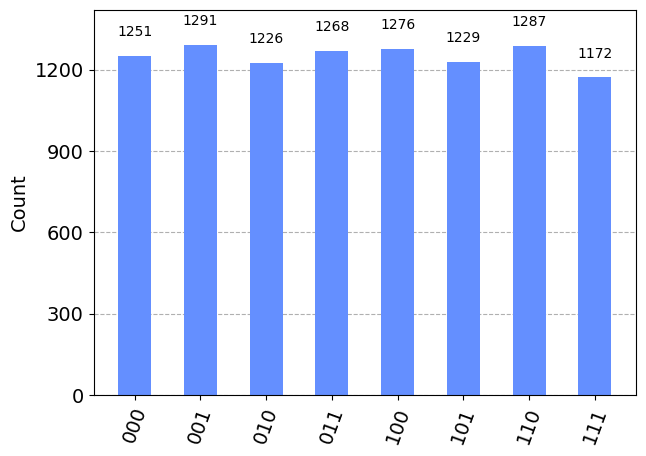

PROBABILIDAD DE ERROR:  0.75
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


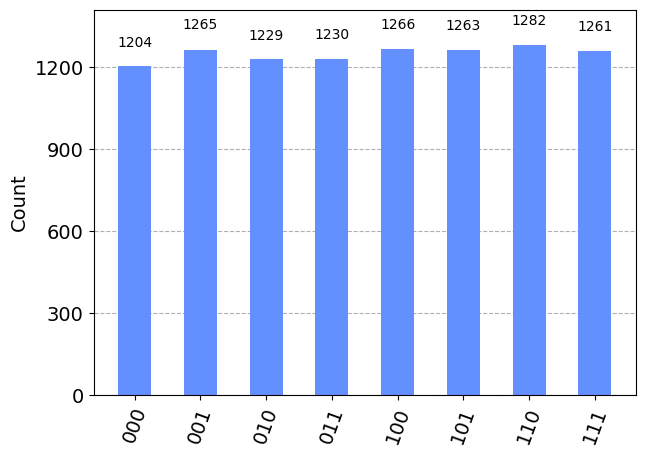

PROBABILIDAD DE ERROR:  0.8
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


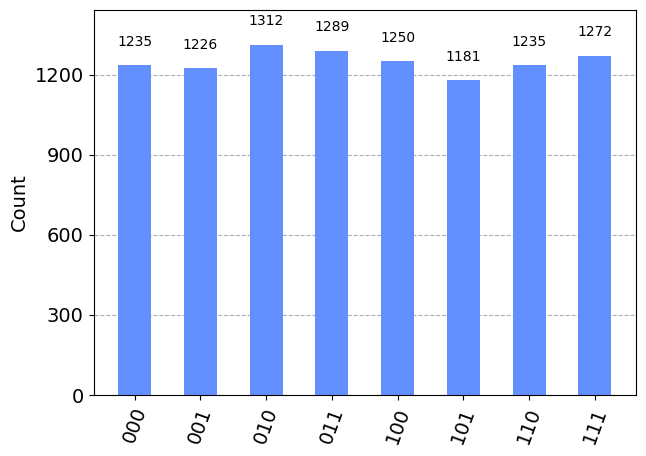

PROBABILIDAD DE ERROR:  0.85
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


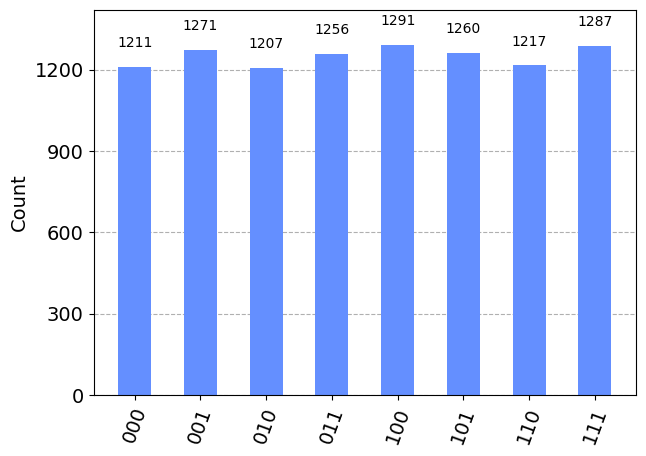

PROBABILIDAD DE ERROR:  0.9
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


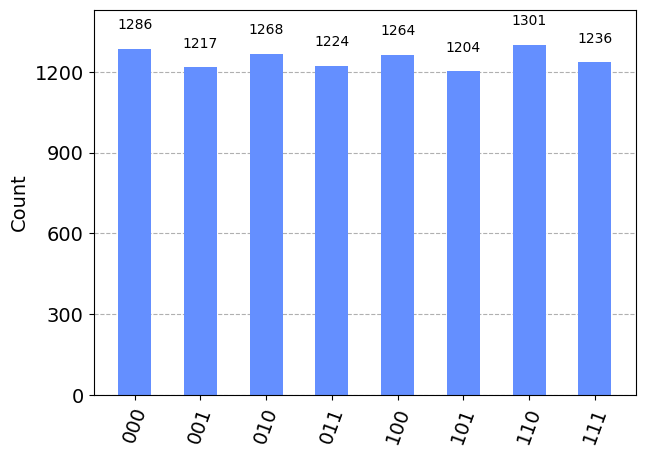

PROBABILIDAD DE ERROR:  0.95
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


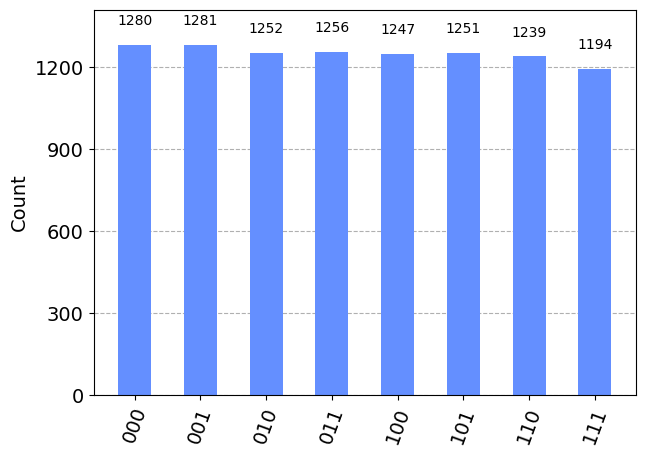

PROBABILIDAD DE ERROR:  1
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


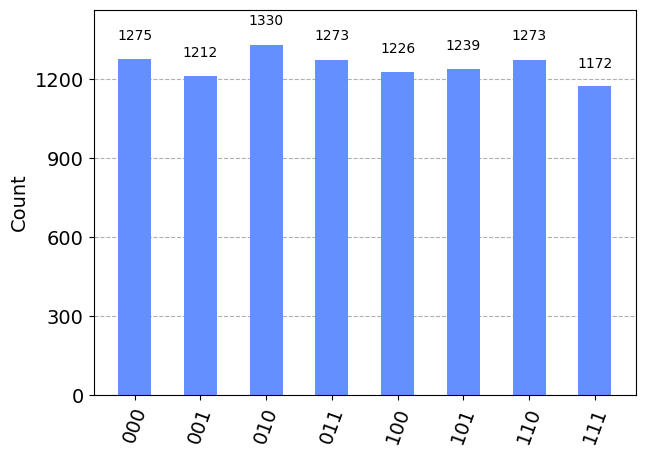

In [90]:
results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
    
    noiseModel = NoiseModel()
    noiseModel = add_controlled_pauli_error(noiseModel,i/2,i/2,['cx','cy','cz'])
    basisGates=noiseModel.basis_gates
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.draw("mpl"))
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)

In [91]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts2=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts2.append(currentCount/shots)
#print(successCounts2)

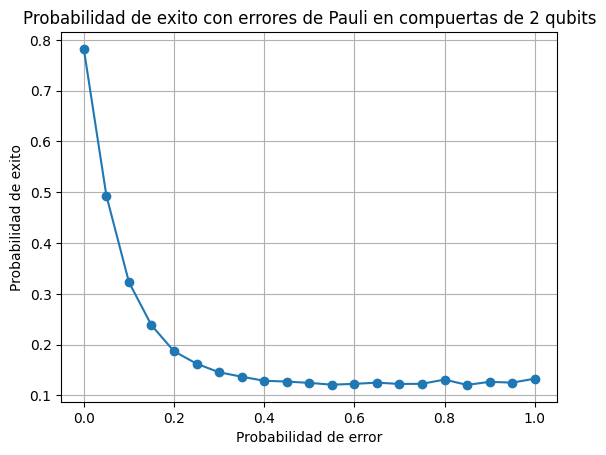

In [92]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts2, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 2 qubits')

# Mostrar el gráfico
plt.grid(True)
plt.show()

## Conclusiones

Los resultados obtenidos para simulación de ruido de Pauli en compuertas de 1 qubit y de 2 qubits son los siguientes: 

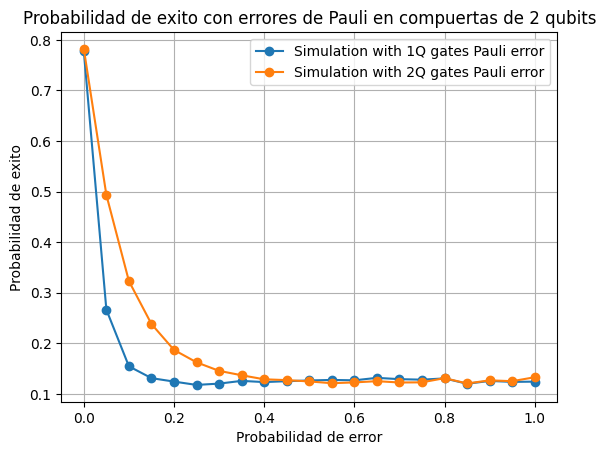

In [93]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts1, marker='o', linestyle='-', label='Simulation with 1Q gates Pauli error')
plt.plot(errorProbabilities, successCounts2, marker='o', linestyle='-', label='Simulation with 2Q gates Pauli error')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 2 qubits')

plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

# Preguntas

1-   Estan bien haberle aplicado(en 1QB noise sim) ruido a x,h,sx,rz?
2-   Tendria que agregarle ruido a la compuertad identidad?me parece que si porque, incluso aunque no tenga que
     causar cambios en el qubit, sigue siendo una compuerta que deberia poder sufrir ruido.
3-   Esta bien que me haya quedado mas ruido de 1Q que en 2Q? Creeria que si ya que hay muchas mas compuertas de 1Q
     que de 2Q al momento de transpilar el circuito.

## Referencias

1. StackExchange - Quantum Computing | How to actually send Qiskit code to the que to be ran on an IBM Quantum Computer? https://quantumcomputing.stackexchange.com/questions/26863/how-to-actually-send-qiskit-code-to-the-que-to-be-ran-on-an-ibm-quantum-computer 

2. How to Show Images in Jupyter Notebook?
https://saturncloud.io/blog/how-to-show-images-in-jupyter-notebook/